# Introduction

Integrate in time the vorticity equation.

Run the simple code first.

1. Then change to $Re=10$, $nx=11$, $dt=0.035$, $dpic=0.025$ and $tfinal=0.525$. The plot of the streamfunction should show the numerical instability. Decreasing $dt$ to 0.03 nearly stabilises the result at this $tfinal$, while $dt=0.025$ works to $tfinal=3.0$. This value of $dt$ is the marginal value, but that is for large grids, and small grids are slightly more stable. Best to work at $dt=0.2*Re*h*h$

1. The code first calculates the boundary conditions to first-order, and then extrapolates these results to apply the conditions to second-order. Use this second-order code. Change to  $Re=10$, $nx=11$, $dpic=0.1$ and $tfinal=1.0$ and $dt=0.02$. Find the value of $\omega(x=0.5,y=0.5,t=1.0)$. Now decrease $dt$ to 0.01, 0.005, 0.0025 and 0.001. Then with $nx=15$ try $dt$ = 0.01 (largest stable value), 0.005, 0.0025 and 0.001. Finally with $nx=21$ try $dt=$ 0.005 (largest stable value), 0.0025 and 0.001. Plot these results for $\psi(x=0.5,y=0.5,t=1.0)$ as a function of $dt$. **You could experiment by deleting the lines of the code that apply the boundary conditions at second-order.**

1. Now set $tfinal=3.0$, $dpic=0.1$ and $dt=0.2*Re*h*h$ and obtain $\omega(x=0.5,y=0.5,t)$ to find how long it takes the vorticity to attain a steady value within 4 significant figures. Compare your plots for the steady state of the streamfunction and the vorticity.

1. Gather results for different spatial resolutions $nx$ for the steady horizontal velocity $u$ at the mid-section $x=0.5$, and plot on top of one another.

1. The code calculates the force on the top plate to second-order accuracy. Find the steady force for different spatial resolutions, $nx=11$, 15, 21, 29 and 41. Plot the force as a function of the grid size $h$.

1. Change the top slip boundary condition from $u=\sin^2\pi x$ to $u=1$, i.e change

    $$
    w(i,nx)= -(sin(pi*(i-1)*h)*sin(pi*(i-1)*h)... 
    $$

    to

    $$
    w(i,nx) = -1...
    $$

    Find the force on the top plate for various spatial resolutions, say $nx= 10$, 14, 20, 28 and 40. **Show that the force diverges as the resolution increases as $F = 4.32\ln(1/h) - 3.75$.**

# Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg

from collections import defaultdict

# Sparse solver

In [22]:
def construct_laplacian_kernel_matrix(N, h):
    # Construct the matrix that defines the linear system

    rows = []
    cols = []
    values = []
    
    for i in range(N):
        for j in range(N):
            rows.append(N * i + j)
            cols.append(N * i + j)
            values.append(-4 / h ** 2)
            
            if i - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * (i - 1) + j)
                values.append(1 / h ** 2)

            if j - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * i + (j - 1))
                values.append(1 / h ** 2)

            if i + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * (i + 1) + j)
                values.append(1 / h ** 2)

            if j + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * i + (j + 1))
                values.append(1 / h ** 2)
    
    return rows, cols, values

In [23]:
# Fast Poisson solver that exploits the sparsity of the problem. Assumes psi=0 on the boundaries
def sparse_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the sparse matrix
    rows, cols, values = construct_laplacian_kernel_matrix(N, h)

    # Create the sparse matrix from the above information
    kernel_matrix_sparse = scipy.sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    
    # Solve the sparse linear system
    psi = scipy.sparse.linalg.spsolve(
        A=kernel_matrix_sparse,
        b=-w[1:-1, 1:-1].flatten().reshape((N ** 2, 1))
    )
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


In [24]:
# Incorporates both the Poisson problem and time-stepping for the vorticity
def solve_using_timestepping(N, Re, tfinal, dt=None, print_every=0.0):
    nx = N + 1 # i.e. N = 10
    ny = nx # square domain
    h = 1 / N # h = dx (=dy) = 1 / N; x-size is 1, y-size is ny/nx
    
    w = np.zeros(shape=(nx, ny)) # vorticity
    psi = np.zeros(shape=(nx, ny)) # streamfunction
    dw_dt = np.zeros(shape=(nx, ny)) # dw/dt    
    
    if dt is None:
        dt = np.round(0.2 * Re * h ** 2, 8) # 0.8 * marginal value
    
    omega_mid = []
    
    t = 0
    while t < tfinal:
        # Start by solving the Poisson problem
        psi = sparse_solver(w)

        
        # Now time-step vorticity

        
        # First calculate BCs to 1st order

        # y = 0. Note U_wall = 0
        w[1:nx - 1, 0] = -((psi[1:nx - 1, 1] - psi[1:nx - 1, 0]) / h - 0) / (0.5 * h)
        # y = 1. Note U_wall is given here
        w[1:nx - 1, ny - 1] = -(
            np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2 -
            (psi[1:nx - 1, ny - 1] - psi[1:nx - 1, ny - 2]) / h
        ) / (0.5 * h)
        
        # x = 0. Note U_wall = 0
        w[0, 1:ny - 1] = (-(psi[1, 1:ny - 1] - psi[0, 1:ny - 1]) / h - 0) / (0.5 * h)
        # x = 1. Note U_wall = 0
        w[nx - 1, 1:ny - 1] = (0 - (-(psi[nx - 1, 1:ny - 1] - psi[nx - 2, 1:ny - 1]) / h)) / (0.5 * h)

        
        # Compute the 2nd order correction to the BCs
        
        # y = 0
        w[1:nx - 1, 0] = (4 * w[1:nx - 1, 0] - w[1:nx - 1, 1]) / 3
        # y = 1
        w[1:nx - 1, ny - 1] = (4 * w[1:nx - 1, ny - 1] - w[1:nx - 1, ny - 2]) / 3
        
        # x = 0
        w[0, 1:ny - 1] = (4 * w[0, 1:ny - 1] - w[1, 1:ny - 1]) / 3

        # x = 1
        w[nx - 1, 1:ny - 1] =(4 * w[nx - 1, 1:ny - 1] - w[nx - 2, 1:ny - 1]) / 3

        # We can now find dw/dt
        dw_dt[1:nx - 1, 1:ny - 1] = (
            -(
                (psi[1:nx - 1, 2:ny] - psi[1:nx - 1, 0:ny - 2]) *
                (w[2:nx, 1:ny - 1] - w[0:nx - 2, 1:ny - 1])
            ) / (4 * h ** 2) + 
            (
                (psi[2:nx, 1:ny - 1] - psi[0:nx - 2, 1:ny - 1]) *
                (w[1:nx - 1, 2:ny] - w[1:nx - 1, 0:ny - 2])
            ) / (4 * h ** 2) + 
            (
                w[2:nx, 1:ny - 1] + w[0:nx - 2, 1:ny - 1] +
                w[1:nx - 1, 2:ny] + w[1:nx - 1, 0:ny - 2] -
                4 * w[1:nx - 1 , 1:ny - 1]
            ) / (Re * h ** 2)
        )

        # Finally, update w
        w[1:nx - 1, 1:ny - 1] = w[1:nx - 1, 1:ny - 1] + dw_dt[1:nx - 1, 1:ny - 1] * dt
        
        # One pass done, increment time
        t = np.round(t + dt, 8)
        
        # Print
        if print_every > 0:
            if 0 <= np.round(t % print_every, 8) < dt:
                print(f"t={t:.5f}; w(0.5, 0.5)={w[nx // 2, ny // 2]}")
        
        omega_mid.append(w[nx // 2, ny // 2])
    
    return w, psi, np.array(omega_mid)


In [25]:
solve = solve_using_timestepping

In [26]:
# # First calculate BCs to 1st order

# # y = 0. Note U_wall = 0
# w[1:-1, 0] = -((psi[1:-1, 1] - psi[1:-1, 0]) / h - 0) / (0.5 * h)
# # y = 1. Note U_wall is given here
# w[1:nx - 1, ny - 1] = -(
#     np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2 -
#     (psi[1:nx - 1, ny - 1] - psi[1:nx - 1, ny - 2]) / h
# ) / (0.5 * h)

# # x = 0. Note U_wall = 0
# w[0, 1:ny - 1] = (-(psi[1, 1:ny - 1] - psi[0, 1:ny - 1]) / h - 0) / (0.5 * h)
# # x = 1. Note U_wall = 0
# w[nx - 1, 1:ny - 1] = (0 - (-(psi[nx - 1, 1:ny - 1] - psi[nx - 2, 1:ny - 1]) / h)) / (0.5 * h)


# # Compute the 2nd order correction to the BCs

# # y = 0
# w[1:-1, 0] = (4 * w[1:-1, 0] - w[1:-1, 1]) / 3
# # y = 1
# w[1:-1, -1] = (4 * w[1:-1, -1] - w[1:-1, -2]) / 3

# # x = 0
# w[0, 1:-1] = (4 * w[0, 1:-1] - w[1, 1:-1]) / 3

# # x = 1
# w[-1, 1:-1] =(4 * w[-1, 1:-1] - w[-2, 1:-1]) / 3

# Newton-Raphson solver

Tries to solve directly for the steady state.

In [27]:
# Given the vorticity, solve the Poisson eqn. to find the streamfunction
def get_standard_basis_vector(size, i):
    vec = np.zeros((size, 1))
    vec[i] = 1.0
    
    return vec


def get_jacobian(f, x, N, h, Re):
    f_evaluated = f(x=x, N=N, h=h, Re=Re)
    
    # Jacobian is sparse
    return scipy.sparse.csr_matrix(
        np.hstack([(
            f(x=x + h * get_standard_basis_vector(size=x.shape[0], i=i), N=N, h=h, Re=Re) -
            f_evaluated
        ) for i in range(x.shape[0])])
    )


def reconstruct_w(w_tmp, N):
    w = np.zeros((N+1, N+1))
    
    w[:1, 1:-1] = w_tmp[0*(N-1):1*(N-1)].T
    w[-1:, 1:-1] = w_tmp[1*(N-1):2*(N-1)].T
    w[1:-1, :1] = w_tmp[2*(N-1):3*(N-1)]
    w[1:-1, -1:] = w_tmp[3*(N-1):4*(N-1)]
    w[1:-1, 1:-1] = w_tmp[4*(N-1):].reshape((N - 1, N - 1))
    
    return w


def cut_corners(x):
    return np.concatenate([
        x[0, 1:-1], x[-1, 1:-1], x[1:-1, 0], x[1:-1, -1], x[1:-1, 1:-1].flatten()
    ])


def f(x, N, h, Re):
    # this N is different from before
#     psi, w = x[:(N - 1) ** 2], x[(N - 1) ** 2:]
    w = x[(N - 1) ** 2:]
    
    # Reshape to make it easier to calculate
#     psi = psi.reshape(N - 1, N - 1)
#     psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    # Reshape to make it easier to calculate
    psi = np.zeros((N + 1, N + 1))
    psi[1:-1, 1:-1] = x[:(N - 1) ** 2].reshape(N - 1, N - 1)
    
    w = reconstruct_w(w_tmp=w, N=N)
    w = w.reshape(N + 1, N + 1)
    
    # Calculate the equations coming from the Poisson equation
    f_poisson = -4 * psi[1:-1, 1:-1] + psi[2:, 1:-1] + psi[:-2, 1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2]
    f_poisson = f_poisson + h ** 2 * w[1:-1, 1:-1]
    
    # Calculate contributions coming from the vorticity transport equation
    f_w = np.zeros_like(w)
    
    # Calculate the sides first
    # y = 0, U_wall = 0
    f_w[1:-1, 0] = h ** 2 * (w[1:-1, 1] + 3 * w[1:-1, 0]) + 8 * (psi[1:-1, 1] - psi[1:-1, 0])
    # y = 1, U_wall is known here
    f_w[1:-1, -1] = h ** 2 * (w[1:-1, -2] + 3 * w[1:-1, -1]) + 8 * (
        h * np.sin(np.pi * np.arange(1, w.shape[0] - 1) * h) ** 2 - (
            psi[1:-1, -1] - psi[1:-1, -2]
        )
    )
    # x = 0
    f_w[0, 1:-1] = h ** 2 * (w[1, 1:-1] + 3 * w[0, 1:-1]) + 8 * (psi[1, 1:-1] - psi[0, 1:-1])
    # x = 1
    f_w[-1, 1:-1] = h ** 2 * (w[-2, 1:-1] + 3 * w[-1, 1:-1]) - 8 * (psi[-1, 1:-1] - psi[-2, 1:-1])
    
    # Calculate w on the interior
    f_w[1:-1, 1:-1] = (
        -4 * w[1:-1, 1:-1] + w[2:, 1:-1] + w[:-2, 1:-1] + w[1:-1, 2:] + w[1:-1, :-2] +
        Re * (
            (psi[2:, 1:-1] - psi[:-2, 1:-1]) * (w[1:-1, 2:] - w[1:-1, :-2])
        ) / 4 -
        Re * (
            (psi[1:-1, 2:] - psi[1:-1, :-2]) * (w[2:, 1:-1] - w[:-2, 1:-1])
        ) / 4
    )
    
    return np.concatenate([f_poisson.flatten(), cut_corners(x=f_w)], axis=0).reshape(-1, 1)


def newton_iterator(x, f, J, N, h, Re, TOL=1e-8, max_iter=10, quiet=True):
    '''
        - x: initial guess
        - f: evaluates the function given x, w, h
        - J: evaluates the Jacobian given N, h
        - N: number of grid points
        - h: grid size
        - Re: Reynolds number
    '''
    
    n_iter = 0 # number of iterations
    
    # Initialization
    f_current = f(x=x, N=N, h=h, Re=Re)
    
    # Check if the initial guess is a solution
    f_norm = scipy.linalg.norm(f_current)
    if f_norm <= TOL:
        if not quiet:
            print(f"n_iter={n_iter}")

        return x, n_iter
    
    while n_iter < max_iter:
        n_iter += 1
        Jacobian = J(f=f, x=x, N=N, h=h, Re=Re)
        
        dx = scipy.sparse.linalg.spsolve(Jacobian, -h * f_current).reshape((-1, 1))
        x_next = x + dx
        
        f_current = f(x=x_next, N=N, h=h, Re=Re)
        
        f_norm = scipy.linalg.norm(f_current)
        if not quiet:
            print(f"iter={n_iter}; residual={f_norm}; dx={scipy.linalg.norm(dx)}")
        if f_norm <= TOL:
            break
        
        x = x_next
        
    if not quiet:
        print(f"n_iter={n_iter}")
    
    return x_next, n_iter


def newton_solver(N, Re, TOL=1e-8, max_iter=10, quiet=True):
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N
    
    # Initialization
    # Size (N - 1) ** 2 (for streamfunction) + (N + 1) ** 2 (for vorticity) - 4 (corners of vorticity)
    x0 = np.zeros(((N - 1) ** 2 + (N + 1) ** 2 - 4, 1))

    solution, n_iter = newton_iterator(
        x=x0, f=f, J=get_jacobian,
        N=N, h=h, Re=Re,
        TOL=TOL, max_iter=max_iter, quiet=quiet
    )
    
    psi, w = solution[:(N - 1) ** 2], solution[(N - 1) ** 2:]
    
    # Get final psi
    psi = psi.reshape(N - 1, N - 1)
    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    # Get final w
    w = reconstruct_w(w_tmp=w, N=N)
    w = w.reshape(N + 1, N + 1)
    
    return w, psi, n_iter


Test for Re = 0:

In [28]:
# N = 20
# Re = 0 # i.e. viscosity mu = inf

# w, psi, _ = newton_solver(N=N, Re=Re, quiet=False)
# np.any(w), np.any(psi)

In [29]:
N = 20
Re = 10 # i.e. viscosity mu = 0.1

w, psi, _ = newton_solver(N=N, Re=Re, quiet=False)
np.any(w), np.any(psi)

iter=1; residual=1.0836381666439985; dx=39.71450891546256
iter=2; residual=0.0015404929313149343; dx=2.273926820301347
iter=3; residual=8.799674792288097e-10; dx=0.0014642597837481001
n_iter=3


(True, True)

# Profiling

In [30]:
# N = 50
# Re = 10 # i.e. viscosity mu = 0.1

# %prun newton_solver(N=N, Re=Re, quiet=True)

# Initialization

In [31]:
%%time

dpic = 0.5

N = 20
Re = 10 # i.e. mu = 0.1

tfinal = 3.5
dt = 0.2 * Re / (N ** 2)

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, _ = newton_solver(N=N, Re=Re, quiet=False)
w2, psi2, _ = solve_using_timestepping(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)
# w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)

iter=1; residual=1.0836381666439985; dx=39.71450891546256
iter=2; residual=0.0015404929313149343; dx=2.273926820301347
iter=3; residual=8.799674792288097e-10; dx=0.0014642597837481001
n_iter=3
t=0.50000; w(0.5, 0.5)=-0.534505970956631
t=1.00000; w(0.5, 0.5)=-0.6391565730049941
t=1.50000; w(0.5, 0.5)=-0.6466476560907707
t=2.00000; w(0.5, 0.5)=-0.6471822817711573
t=2.50000; w(0.5, 0.5)=-0.6472204426025078
t=3.00000; w(0.5, 0.5)=-0.6472231665567474
t=3.50000; w(0.5, 0.5)=-0.6472233609961568
CPU times: user 2.77 s, sys: 0 ns, total: 2.77 s
Wall time: 2.82 s


In [32]:
np.allclose(w, w2), np.allclose(psi, psi2)

(True, True)

# Speeds

In [33]:
# %%time

# N_values = [10, 20, 40, 50, 70, 100]
# N_values = [10, 20, 40, 50, 70]
# Re = 10 # i.e. mu = 0.1

# tfinal = 3.5

# with open("outputs/optimized_newton_vs_iterative_speed_2.csv", "wt") as file:
#     file.write("N,newton,iterative\n")
#     for N in N_values:
#         print(f"N={N}")
#         file.write(f"{N},")
#         dt = np.round(0.2 * Re / (N ** 2), 8)

#         w, psi, n_iter = newton_solver(N=N, Re=Re)
#         print(f"Newton converged in {n_iter} iterations")
#         w2, psi2, _ = solve_using_timestepping(N=N, Re=Re, tfinal=tfinal)

#         assert np.allclose(w, w2) and np.allclose(psi, psi2)

#         time = %timeit -o -q -n 1 -r 1 newton_solver(N=N, Re=Re)
#         print(time.average, time.stdev)
#         file.write(f"{time.average},")

#         time = %timeit -o -q -n 1 -r 1 solve_using_timestepping(N=N, Re=Re, tfinal=tfinal)
#         print(time.average, time.stdev)
#         file.write(f"{time.average}\n")

#         print()

        
# # Have to decrease time-step
# # Increasing N of steps is what is important

# # Steady state might not exist
# # Becomes philosophical
# # -> Steady state is likely to exist, but might not be stable (think of perturbing)

# # Good initial guess

# # See how solutions vary with Re (recirculation areas in bottom left and right)
# # Symmetry should be broken with increasing Re

# # Increasing Re should make the problem unstable
# # Iterative should win here (Newton would find the unstable steady)

# # Find the critical Re
# # Could also try finding it by trying lots of values of Re (time consuming)

# Results

## Plots

In [34]:
# Helper function for plotting
def plot(x, y, z, label, zlim=None, levels=None, offset=None, figsize=(10, 10), plot_contour=True):
    ax = plt.figure(figsize=figsize).add_subplot(projection="3d")

    # Plot the surface
    ax.plot_surface(x, y, z)
    
    if plot_contour:
        ax.contour(
            x, y, z, levels=levels,
            zdir="z", offset=offset, cmap=cm.binary
        )
        ax.set(zlim=zlim)

    ax.set(
        xlabel="x", ylabel="y", zlabel=label,
    )

    plt.show()

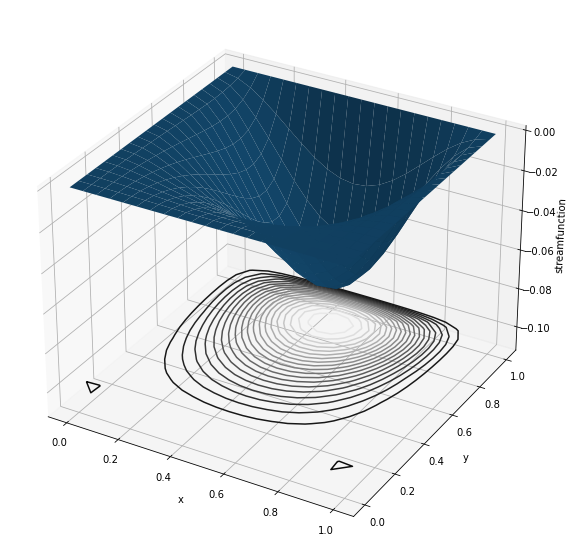

In [35]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [36]:
def find_min(z):
    return np.unravel_index(z.argmin(), z.shape)

In [37]:
# Min location
min_location = find_min(psi)
min_location, (x_grid[min_location], y_grid[min_location]), psi[min_location]

((10, 16), (0.5, 0.8), -0.08010118707181207)

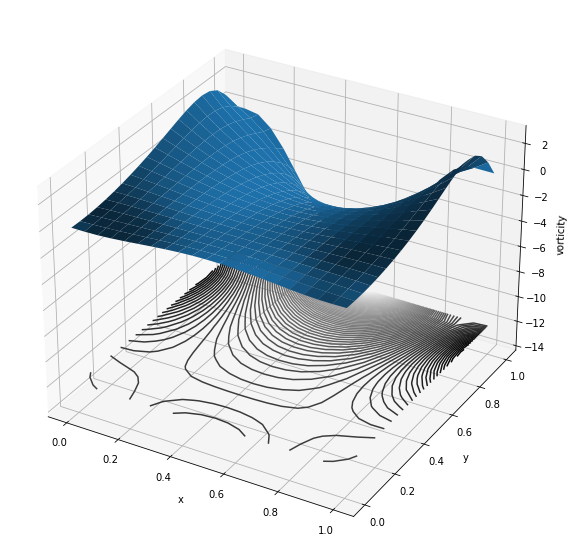

In [38]:
plot(
    x=x_grid, y=y_grid, z=w,
    label="vorticity", levels=80,
    offset=-12, zlim=(-14, 3)
)

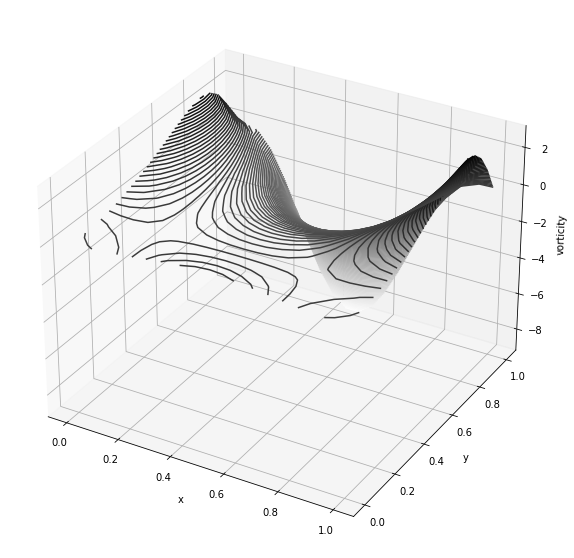

In [39]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

ax.contour3D(x_grid, y_grid, w, levels=145, cmap="binary")
ax.set(
    xlabel="x", ylabel="y", zlabel="vorticity",
)

plt.show()

In [40]:
# Min location
min_location = find_min(w)
min_location, (x_grid[min_location], y_grid[min_location]), w[min_location]

((10, 20), (0.5, 1.0), -8.954402809833521)

## Calculating u at middle

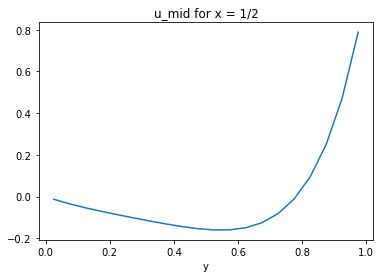

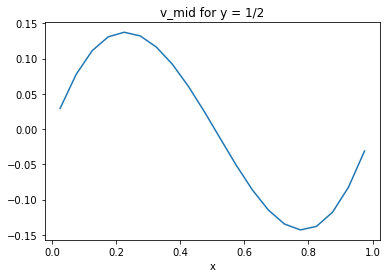

In [41]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[i, :-1] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");
plt.show()

j = nx // 2
v_mid = -(psi[1:, j] - psi[:-1, j]) / h
plt.plot(x_grid[:-1, j] + h / 2, v_mid)
plt.title("v_mid for y = 1/2")
plt.xlabel("x");
plt.show()

## Calculating force

In [59]:
def calculate_force(psi, nx, ny, h):
    # 1st order: (p[i,ny] - 2*p[i,ny-1] + p[i,ny-2])/h;
    # 2nd order:(2*p[i,ny] - 5*p[i,ny-1] + 4*p[i,ny-2] -p[i,ny-3])/h;
    
    return np.sum(
        2 * psi[1:nx - 1, ny - 1] -
        5 * psi[1:nx - 1, ny - 2] +
        4 * psi[1:nx - 1, ny - 3] -
        psi[1:nx - 1, ny - 4]
    ) / h

In [60]:
calculate_force(psi, nx=nx, ny=ny, h=h)

IndexError: index 20 is out of bounds for axis 1 with size 11

# Exercise 1

In [24]:
%%time

# Should be unstable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 0.525
dt = 0.035

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)

t=0.03500; w(0.5, 0.5)=0.0
t=0.07000; w(0.5, 0.5)=0.0
t=0.10500; w(0.5, 0.5)=0.0
t=0.14000; w(0.5, 0.5)=0.0
t=0.17500; w(0.5, 0.5)=-0.13931884366753844
t=0.21000; w(0.5, 0.5)=-0.18113994338223866
t=0.24500; w(0.5, 0.5)=-0.2832818989864808
t=0.28000; w(0.5, 0.5)=-0.33024276598809027
t=0.31500; w(0.5, 0.5)=-0.3946990774587819
t=0.35000; w(0.5, 0.5)=-0.4286988571487426
t=0.38500; w(0.5, 0.5)=-0.5160422384090964
t=0.42000; w(0.5, 0.5)=-0.33612442874103154
t=0.45500; w(0.5, 0.5)=-1.0618425191481484
t=0.49000; w(0.5, 0.5)=0.9000825628493532
t=0.52500; w(0.5, 0.5)=-4.158961389523041
CPU times: user 26 ms, sys: 6.8 ms, total: 32.8 ms
Wall time: 30.9 ms


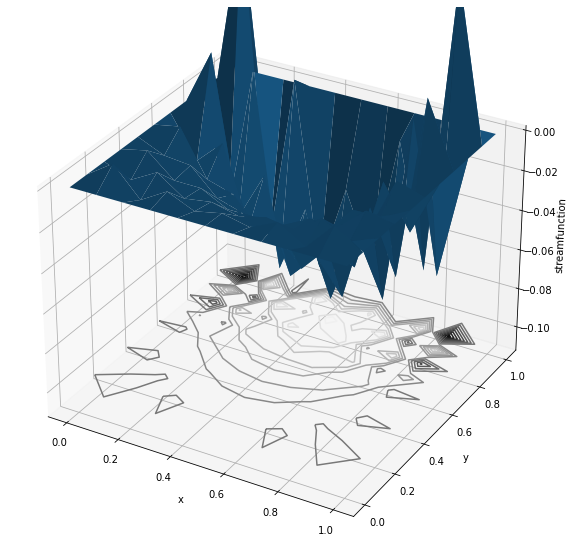

In [25]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [26]:
%%time

# Almost stable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 0.525
dt = 0.03

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)

t=0.03000; w(0.5, 0.5)=0.0
t=0.06000; w(0.5, 0.5)=0.0
t=0.09000; w(0.5, 0.5)=0.0
t=0.12000; w(0.5, 0.5)=0.0
t=0.15000; w(0.5, 0.5)=-0.06453626408088507
t=0.18000; w(0.5, 0.5)=-0.12702719234818682
t=0.21000; w(0.5, 0.5)=-0.19576682755294986
t=0.24000; w(0.5, 0.5)=-0.257786865692358
t=0.27000; w(0.5, 0.5)=-0.31399006047899014
t=0.30000; w(0.5, 0.5)=-0.36184714007871105
t=0.33000; w(0.5, 0.5)=-0.41126008803277786
t=0.36000; w(0.5, 0.5)=-0.42698282203806104
t=0.39000; w(0.5, 0.5)=-0.5068231713219556
t=0.42000; w(0.5, 0.5)=-0.43383494045854104
t=0.45000; w(0.5, 0.5)=-0.6412446995878762
t=0.48000; w(0.5, 0.5)=-0.3373787666712473
t=0.51000; w(0.5, 0.5)=-0.8913956659186608
t=0.54000; w(0.5, 0.5)=-0.03964578931042306
CPU times: user 35.7 ms, sys: 4.7 ms, total: 40.4 ms
Wall time: 35.2 ms


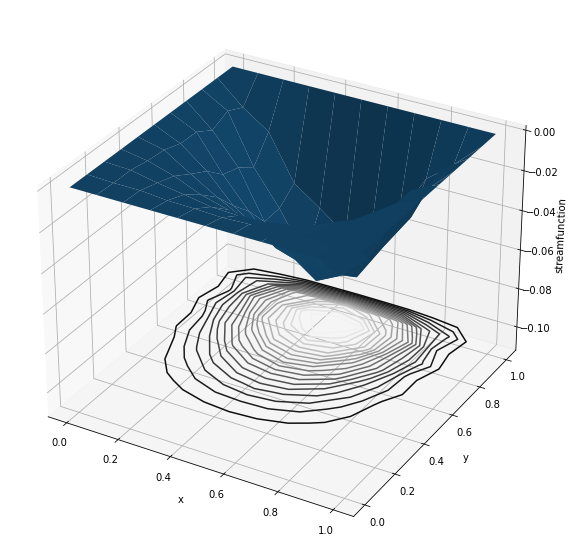

In [27]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [28]:
%%time

# Stable

dpic = 0.025

N = 10
Re = 10 # i.e. mu = 0.1

tfinal = 3.0
dt = 0.025 # marginal value

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt)

CPU times: user 170 ms, sys: 337 µs, total: 170 ms
Wall time: 243 ms


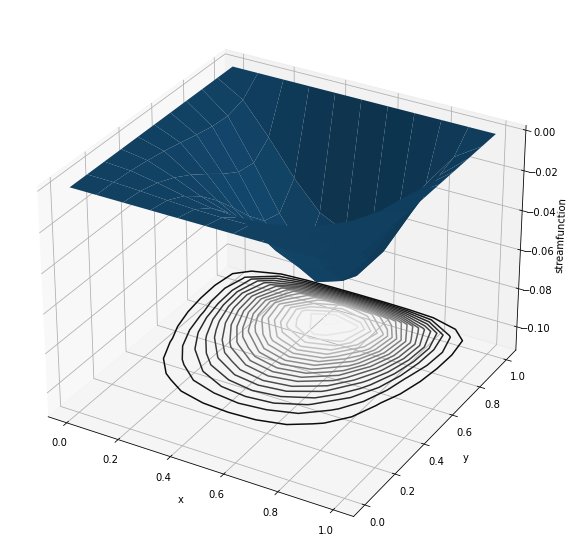

In [29]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

# Exercise 2

In [30]:
%%time


N_to_t = {
    10: [0.02, 0.01, 0.005, 0.0025, 0.001],
    14: [0.01, 0.005, 0.0025, 0.001],
    20: [0.005, 0.0025, 0.001],
}
results = defaultdict(list)

dpic = 0.1

Re = 10 # i.e. mu = 0.1

tfinal = 1.0

for N, dts in N_to_t.items():
    for dt in dts:
        w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt)
        
        results[N].append(w[(N + 1) // 2, (N + 1) // 2])

CPU times: user 10.1 s, sys: 21.7 ms, total: 10.2 s
Wall time: 10.2 s


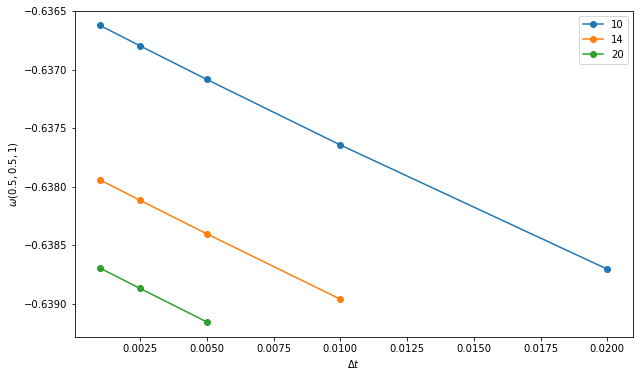

In [31]:
plt.figure(figsize=(10, 6))

for N, omegas in results.items():
    plt.plot(N_to_t[N], omegas, label=N, marker="o")

plt.xlabel(r"$\Delta t$")
plt.ylabel(r"$\omega(0.5, 0.5, 1)$")
plt.legend()
plt.show()

# Exercise 3

In [32]:
%%time

# Stable

dpic = 0.5

N = 40
Re = 10 # i.e. mu = 0.1

tfinal = 3.0

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, omega_mid = solve(N=N, Re=Re, tfinal=tfinal, print_every=dpic)

t=0.50000; w(0.5, 0.5)=-0.5318425795976055
t=1.00000; w(0.5, 0.5)=-0.6392078531937394
t=1.50000; w(0.5, 0.5)=-0.6470209335147183
t=2.00000; w(0.5, 0.5)=-0.6475875194638533
t=2.50000; w(0.5, 0.5)=-0.6476286124379776
t=3.00000; w(0.5, 0.5)=-0.6476315928957449
CPU times: user 29.2 s, sys: 23.5 ms, total: 29.2 s
Wall time: 29.3 s


In [33]:
%%time

N = 40
Re = 10 # i.e. mu = 0.1

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, _ = newton_solver(N=N, Re=Re)

CPU times: user 2.87 s, sys: 140 ms, total: 3.01 s
Wall time: 3.01 s


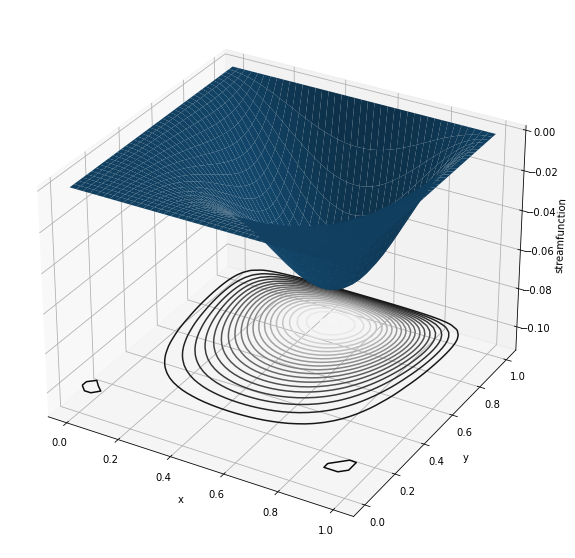

In [34]:
plot(
    x=x_grid, y=y_grid, z=psi,
    label="streamfunction", levels=20,
    offset=-0.1, zlim=(-0.11, 0)
)

In [37]:
# xyz = np.vstack([
#     x_grid.flatten(), y_grid.flatten(), psi.flatten(),
# ]).T
# print(xyz.shape)

# np.savetxt('data/vorticity/streamfunction.txt', xyz, delimiter=' ', fmt=['%.8f', '%.8f', '%.18f'])

(1681, 3)


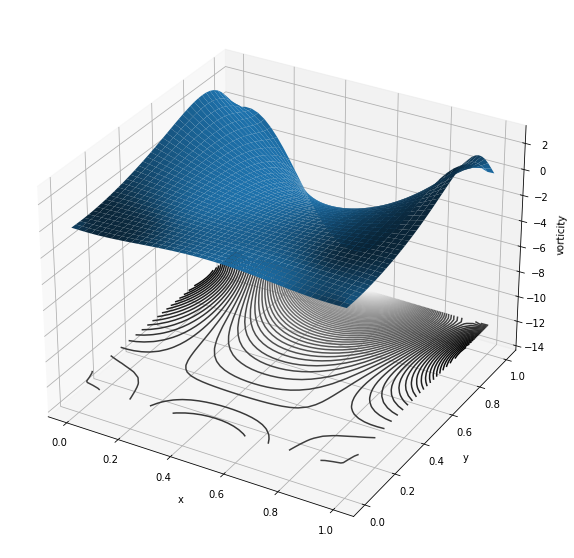

In [38]:
plot(
    x=x_grid, y=y_grid, z=w,
    label="vorticity", levels=80,
    offset=-12, zlim=(-14, 3)
)

In [40]:
# xyz = np.vstack([
#     x_grid.flatten(), y_grid.flatten(), w.flatten(),
# ]).T
# print(xyz.shape)

# np.savetxt('data/vorticity/vorticity.txt', xyz, delimiter=' ', fmt=['%.8f', '%.8f', '%.18f'])

(1681, 3)


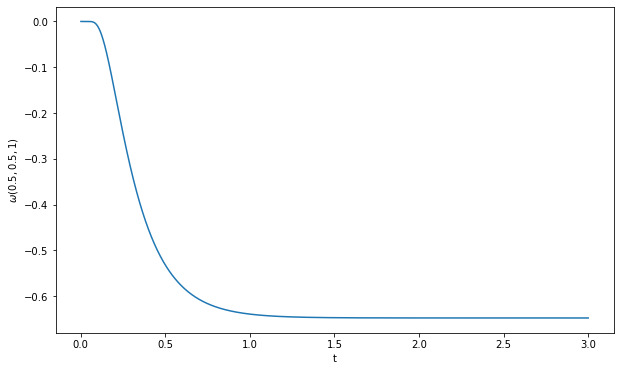

In [130]:
plt.figure(figsize=(10, 6))

dt = 0.2 * Re * h ** 2
time = np.arange(dt, tfinal + dt, dt)
plt.plot(time, omega_mid)

plt.xlabel("t")
plt.ylabel(r"$\omega(0.5, 0.5, 1)$")
plt.show()

# Plot the horizontal line from newtons

In [131]:
# Accurate to 4 sf after
for i in range(50, len(omega_mid)):
    if np.isclose(np.round(np.abs(omega_mid[i] - omega_mid[i - 1]), 4), 0.0):
        print(time[i])
        break

1.0200000000000002


# Time to steady state

2
0.001
t=0.50000; w(0.5, 0.5)=-0.6462423664147656
t=1.00000; w(0.5, 0.5)=-0.6462453178581805
t=1.50000; w(0.5, 0.5)=-0.6462453178636922
t=2.00000; w(0.5, 0.5)=-0.6462453178636922
5
0.0025
t=0.50000; w(0.5, 0.5)=-0.638385264350038
t=1.00000; w(0.5, 0.5)=-0.6464181464787538
t=1.50000; w(0.5, 0.5)=-0.6464591757258616
t=2.00000; w(0.5, 0.5)=-0.6464593852987515
10
0.005
t=0.50000; w(0.5, 0.5)=-0.534505970956631
t=1.00000; w(0.5, 0.5)=-0.6391565730049941
t=1.50000; w(0.5, 0.5)=-0.6466476560907707
t=2.00000; w(0.5, 0.5)=-0.6471822817711573
20
0.01
t=0.50000; w(0.5, 0.5)=-0.2504629757523946
t=1.00000; w(0.5, 0.5)=-0.5371769973185889
t=1.50000; w(0.5, 0.5)=-0.6200815216252824
t=2.00000; w(0.5, 0.5)=-0.6422297014449312
50
0.025
t=0.50000; w(0.5, 0.5)=-0.010154303316345783
t=1.00000; w(0.5, 0.5)=-0.1577445843414374
t=1.50000; w(0.5, 0.5)=-0.34306117421208276
t=2.00000; w(0.5, 0.5)=-0.4745255536896263
100
0.05
t=0.50000; w(0.5, 0.5)=-4.639496962571407e-06
t=1.00000; w(0.5, 0.5)=-0.009332509845191

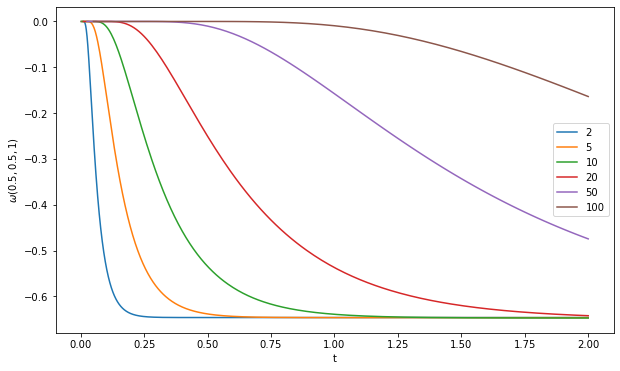

CPU times: user 11.6 s, sys: 71.7 ms, total: 11.6 s
Wall time: 11.8 s


In [132]:
%%time

# Stable

dpic = 0.5

N = 20
Re_values = [0.1, 1, 2, 5, 10, 20, 50, 100]
Re_values = [2, 5, 10, 20, 50, 100]

tfinal = 2.0

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

plt.figure(figsize=(10, 6))

for Re in Re_values:
    print(Re)
    dt = np.round(0.2 * Re * h ** 2, 8)
    print(dt)
    w, psi, omega_mid = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)

    time = np.arange(dt, tfinal + dt, dt)
    plt.plot(time, omega_mid, label=Re)
    

plt.xlabel("t")
plt.ylabel(r"$\omega(0.5, 0.5, 1)$")
plt.legend()
plt.show()

In [133]:
# ax = plt.figure(figsize=figsize).add_subplot(projection="3d")

# # Plot the surface
# ax.plot_surface(x, y, z)

# if plot_contour:
#     ax.contour(
#         x, y, z, levels=levels,
#         zdir="z", offset=offset, cmap=cm.binary
#     )
#     ax.set(zlim=zlim)

# ax.set(
#     xlabel="x", ylabel="y", zlabel=label,
# )

# plt.show()

2
0.001
t=0.50000; w(0.5, 0.5)=-0.6462423664147656
t=1.00000; w(0.5, 0.5)=-0.6462453178581805
t=1.50000; w(0.5, 0.5)=-0.6462453178636922
t=2.00000; w(0.5, 0.5)=-0.6462453178636922
5
0.0025
t=0.50000; w(0.5, 0.5)=-0.638385264350038
t=1.00000; w(0.5, 0.5)=-0.6464181464787538
t=1.50000; w(0.5, 0.5)=-0.6464591757258616
t=2.00000; w(0.5, 0.5)=-0.6464593852987515
10
0.005
t=0.50000; w(0.5, 0.5)=-0.534505970956631
t=1.00000; w(0.5, 0.5)=-0.6391565730049941
t=1.50000; w(0.5, 0.5)=-0.6466476560907707
t=2.00000; w(0.5, 0.5)=-0.6471822817711573
20
0.01
t=0.50000; w(0.5, 0.5)=-0.2504629757523946
t=1.00000; w(0.5, 0.5)=-0.5371769973185889
t=1.50000; w(0.5, 0.5)=-0.6200815216252824
t=2.00000; w(0.5, 0.5)=-0.6422297014449312
50
0.025
t=0.50000; w(0.5, 0.5)=-0.010154303316345783
t=1.00000; w(0.5, 0.5)=-0.1577445843414374
t=1.50000; w(0.5, 0.5)=-0.34306117421208276
t=2.00000; w(0.5, 0.5)=-0.4745255536896263
100
0.05
t=0.50000; w(0.5, 0.5)=-4.639496962571407e-06
t=1.00000; w(0.5, 0.5)=-0.009332509845191

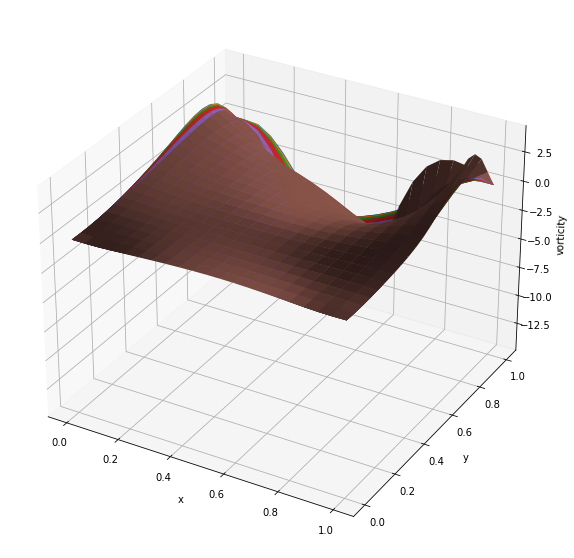

In [135]:
# %matplotlib notebook

dpic = 0.5

N = 20
Re_values = [0.1, 1, 2, 5, 10, 20, 50, 100]
Re_values = [2, 5, 10, 20, 50, 100]

tfinal = 2.0

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

ax = plt.figure(figsize=(10, 10)).add_subplot(projection="3d")

for Re in Re_values:
    print(Re)
    dt = np.round(0.2 * Re * h ** 2, 8)
    print(dt)
    
    w, _, _ = solve(N=N, Re=Re, tfinal=tfinal, dt=dt, print_every=dpic)
    
    ax.plot_surface(x_grid, y_grid, w, label=Re)

ax.set(
    xlabel="x", ylabel="y", zlabel="vorticity",
)
# plt.legend()
plt.show()

# Exercise 4

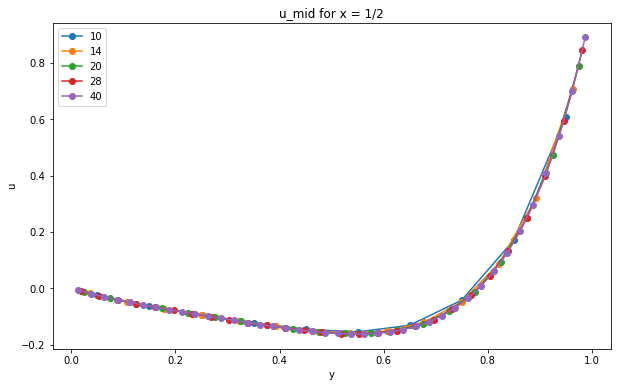

CPU times: user 40.1 s, sys: 90.3 ms, total: 40.2 s
Wall time: 40.7 s


In [41]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

plt.figure(figsize=(10, 6))
for N in [10, 14, 20, 28, 40]:
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)

    i = (N + 1) // 2
    h = 1 / N
    _, y_grid = np.meshgrid(np.linspace(0, 1, N + 1), np.linspace(0, 1, N + 1), indexing="ij")
    u_mid = (psi[i, 1:] - psi[i, :-1]) / h
    plt.plot(y_grid[i, :-1] + h / 2, u_mid, label=N, marker="o")
    
    
plt.xlabel("y");
plt.ylabel("u")
plt.title("u_mid for x = 1/2")
plt.legend()

plt.show()

# Exercise 5

10
14
20
28
40


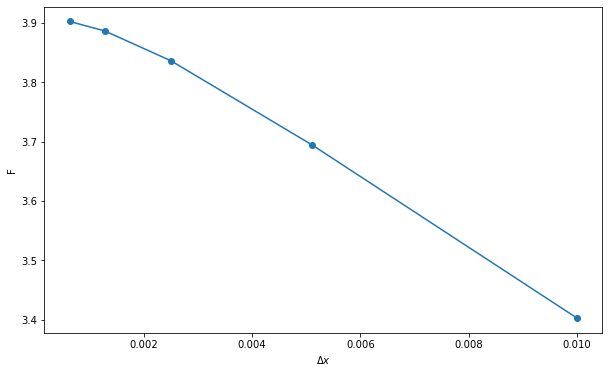

CPU times: user 39.2 s, sys: 0 ns, total: 39.2 s
Wall time: 42.7 s


In [61]:
%%time

# Gives rubbish on first go, so run this twice

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

N_values = np.array([10, 14, 20, 28, 40])
forces = []
for N in N_values:
    print(N)
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)
    
    force = calculate_force(psi, nx=N + 1, ny=N + 1, h=1 / N)
    forces.append(force)
    

plt.figure(figsize=(10, 6))
plt.plot(1 / N_values ** 2, forces, marker="o")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")

plt.show()


In [62]:
forces[-1]

3.902325035975255

In [54]:
# xy = np.vstack([
#     (1 / N_values ** 2).flatten(), np.array(forces).flatten(),
# ]).T
# print(xy.shape)

# np.savetxt('data/vorticity/force_vs_space.txt', xy, delimiter=' ', fmt=['%.18f', '%.18f'])

## Newton

10
14
20
28
40
56


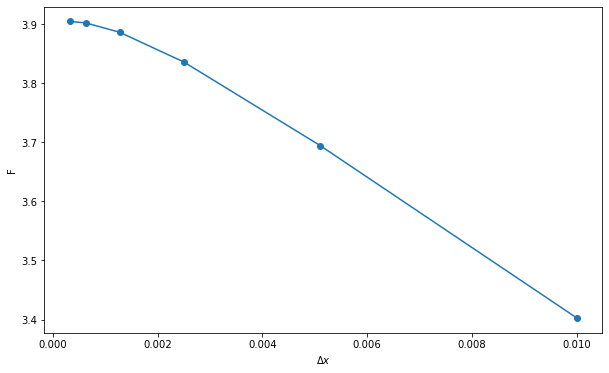

CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 15.9 s


In [65]:
%%time

# Gives rubbish on first go, so run this twice

Re = 10 # i.e. mu = 0.1

N_values = np.array([10, 14, 20, 28, 40, 56])
forces = []

for N in N_values:
    print(N)
    w, psi, _ = newton_solver(N=N, Re=Re)
    
    force = calculate_force(psi, nx=N + 1, ny=N + 1, h=1 / N)
    forces.append(force)
    

plt.figure(figsize=(10, 6))
plt.plot(1 / N_values ** 2, forces, marker="o")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")

plt.show()


In [66]:
forces[-1]

3.9046740110565072

In [68]:
xy = np.vstack([
    (1 / N_values ** 2).flatten(), np.array(forces).flatten(),
]).T
print(xy.shape)

np.savetxt('data/vorticity/force_vs_space_newton.txt', xy, delimiter=' ', fmt=['%.18f', '%.18f'])

(6, 2)


# Exercise 6

In [59]:
# Incorporates both the Poisson problem and time-stepping for the vorticity
# Note that this is a modified version for u=1 at y=1
def modified_solver(N, Re, tfinal, dt=None, print_every=0.0):
    nx = N + 1 # i.e. N = 10
    ny = nx # square domain
    h = 1 / N # h = dx (=dy) = 1 / N; x-size is 1, y-size is ny/nx
    
    w = np.zeros(shape=(nx, ny)) # vorticity
    psi = np.zeros(shape=(nx, ny)) # streamfunction
    dw_dt = np.zeros(shape=(nx, ny)) # dw/dt    
    
    if dt is None:
        dt = np.round(0.2 * Re * h ** 2, 8) # 0.8 * marginal value
    
    omega_mid = []
    
    t = 0
    while t < tfinal:
        # Start by solving the Poisson problem
        psi = sparse_solver(w)

        
        # Now time-step vorticity

        
        # First calculate BCs to 1st order

        # y = 0. Note U_wall = 0
        w[1:nx - 1, 0] = -((psi[1:nx - 1, 1] - psi[1:nx - 1, 0]) / h - 0) / (0.5 * h)
        # y = 1. Note U_wall = 1 is given here
        w[1:nx - 1, ny - 1] = -(
            1 - (psi[1:nx - 1, ny - 1] - psi[1:nx - 1, ny - 2]) / h
        ) / (0.5 * h)
        
        # x = 0. Note U_wall = 0
        w[0, 1:ny - 1] = (-(psi[1, 1:ny - 1] - psi[0, 1:ny - 1]) / h - 0) / (0.5 * h)
        # x = 1. Note U_wall = 0
        w[nx - 1, 1:ny - 1] = (0 - (-(psi[nx - 1, 1:ny - 1] - psi[nx - 2, 1:ny - 1]) / h)) / (0.5 * h)

        
        # Compute the 2nd order correction to the BCs
        
        # y = 0
        w[1:nx - 1, 0] = (4 * w[1:nx - 1, 0] - w[1:nx - 1, 1]) / 3
        # y = 1
        w[1:nx - 1, ny - 1] = (4 * w[1:nx - 1, ny - 1] - w[1:nx - 1, ny - 2]) / 3
        
        # x = 0
        w[0, 1:ny - 1] = (4 * w[0, 1:ny - 1] - w[1, 1:ny - 1]) / 3

        # x = 1
        w[nx - 1, 1:ny - 1] =(4 * w[nx - 1, 1:ny - 1] - w[nx - 2, 1:ny - 1]) / 3

        # We can now find dw/dt
        dw_dt[1:nx - 1, 1:ny - 1] = (
            -(
                (psi[1:nx - 1, 2:ny] - psi[1:nx - 1, 0:ny - 2]) *
                (w[2:nx, 1:ny - 1] - w[0:nx - 2, 1:ny - 1])
            ) / (4 * h ** 2) + 
            (
                (psi[2:nx, 1:ny - 1] - psi[0:nx - 2, 1:ny - 1]) *
                (w[1:nx - 1, 2:ny] - w[1:nx - 1, 0:ny - 2])
            ) / (4 * h ** 2) + 
            (
                w[2:nx, 1:ny - 1] + w[0:nx - 2, 1:ny - 1] +
                w[1:nx - 1, 2:ny] + w[1:nx - 1, 0:ny - 2] -
                4 * w[1:nx - 1 , 1:ny - 1]
            ) / (Re * h ** 2)
        )

        # Finally, update w
        w[1:nx - 1, 1:ny - 1] = w[1:nx - 1, 1:ny - 1] + dw_dt[1:nx - 1, 1:ny - 1] * dt
        
        # One pass done, increment time
        t = np.round(t + dt, 8)
        
        # Print
        if print_every > 0:
            if 0 <= np.round(t % print_every, 8) < dt:
                print(f"t={t:.5f}; w(0.5, 0.5)={w[nx // 2, ny // 2]}")
        
        omega_mid.append(w[nx // 2, ny // 2])
    
    return w, psi, np.array(omega_mid)


10
14
20
28
40


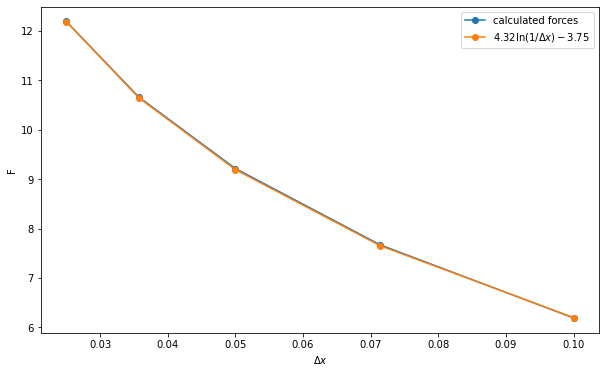

CPU times: user 39.6 s, sys: 90.2 ms, total: 39.7 s
Wall time: 39.8 s


In [60]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

N_values = np.array([10, 14, 20, 28, 40])
forces = []
for N in N_values:
    print(N)
    w, psi, _ = modified_solver(N=N, Re=Re, tfinal=tfinal)
    
    force = calculate_force(psi, ny=N + 1, h=1 / N)
    forces.append(force)


plt.figure(figsize=(10, 6))
plt.plot(1 / N_values, forces, marker="o", label="calculated forces")
plt.plot(1 / N_values, 4.32 * np.log(N_values) - 3.75, marker="o", label=r"$4.32\ln(1/\Delta x) - 3.75$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")
plt.legend()

plt.show()

## Newton

In [61]:
# Given the vorticity, solve the Poisson eqn. to find the streamfunction
def get_standard_basis_vector(size, i):
    vec = np.zeros((size, 1))
    vec[i] = 1.0
    
    return vec


def get_jacobian(f, x, N, h, Re):
    f_evaluated = f(x=x, N=N, h=h, Re=Re)
    
    # Jacobian is sparse
    return scipy.sparse.csr_matrix(
        np.hstack([(
            f(x=x + h * get_standard_basis_vector(size=x.shape[0], i=i), N=N, h=h, Re=Re) -
            f_evaluated
        ) for i in range(x.shape[0])])
    )


def reconstruct_w(w_tmp, N):
    w = np.zeros((N+1, N+1))
    
    w[:1, 1:-1] = w_tmp[0*(N-1):1*(N-1)].T
    w[-1:, 1:-1] = w_tmp[1*(N-1):2*(N-1)].T
    w[1:-1, :1] = w_tmp[2*(N-1):3*(N-1)]
    w[1:-1, -1:] = w_tmp[3*(N-1):4*(N-1)]
    w[1:-1, 1:-1] = w_tmp[4*(N-1):].reshape((N - 1, N - 1))
    
    return w


def cut_corners(x):
    return np.concatenate([
        x[0, 1:-1], x[-1, 1:-1], x[1:-1, 0], x[1:-1, -1], x[1:-1, 1:-1].flatten()
    ])


def modified_f(x, N, h, Re):
    # this N is different from before
#     psi, w = x[:(N - 1) ** 2], x[(N - 1) ** 2:]
    w = x[(N - 1) ** 2:]
    
    # Reshape to make it easier to calculate
#     psi = psi.reshape(N - 1, N - 1)
#     psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    # Reshape to make it easier to calculate
    psi = np.zeros((N + 1, N + 1))
    psi[1:-1, 1:-1] = x[:(N - 1) ** 2].reshape(N - 1, N - 1)
    
    w = reconstruct_w(w_tmp=w, N=N)
    w = w.reshape(N + 1, N + 1)
    
    # Calculate the equations coming from the Poisson equation
    f_poisson = -4 * psi[1:-1, 1:-1] + psi[2:, 1:-1] + psi[:-2, 1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2]
    f_poisson = f_poisson + h ** 2 * w[1:-1, 1:-1]
    
    # Calculate contributions coming from the vorticity transport equation
    f_w = np.zeros_like(w)
    
    # Calculate the sides first
    # y = 0, U_wall = 0
    f_w[1:-1, 0] = h ** 2 * (w[1:-1, 1] + 3 * w[1:-1, 0]) + 8 * (psi[1:-1, 1] - psi[1:-1, 0])
    # y = 1, U_wall is known here
    f_w[1:-1, -1] = h ** 2 * (w[1:-1, -2] + 3 * w[1:-1, -1]) + 8 * (
        h * 1 ** 2 - (
            psi[1:-1, -1] - psi[1:-1, -2]
        )
    )
    # x = 0
    f_w[0, 1:-1] = h ** 2 * (w[1, 1:-1] + 3 * w[0, 1:-1]) + 8 * (psi[1, 1:-1] - psi[0, 1:-1])
    # x = 1
    f_w[-1, 1:-1] = h ** 2 * (w[-2, 1:-1] + 3 * w[-1, 1:-1]) - 8 * (psi[-1, 1:-1] - psi[-2, 1:-1])
    
    # Calculate w on the interior
    f_w[1:-1, 1:-1] = (
        -4 * w[1:-1, 1:-1] + w[2:, 1:-1] + w[:-2, 1:-1] + w[1:-1, 2:] + w[1:-1, :-2] +
        Re * (
            (psi[2:, 1:-1] - psi[:-2, 1:-1]) * (w[1:-1, 2:] - w[1:-1, :-2])
        ) / 4 -
        Re * (
            (psi[1:-1, 2:] - psi[1:-1, :-2]) * (w[2:, 1:-1] - w[:-2, 1:-1])
        ) / 4
    )
    
    return np.concatenate([f_poisson.flatten(), cut_corners(x=f_w)], axis=0).reshape(-1, 1)


def newton_iterator(x, f, J, N, h, Re, TOL=1e-8, max_iter=10, quiet=True):
    '''
        - x: initial guess
        - f: evaluates the function given x, w, h
        - J: evaluates the Jacobian given N, h
        - N: number of grid points
        - h: grid size
        - Re: Reynolds number
    '''
    
    n_iter = 0 # number of iterations
    
    # Initialization
    f_current = f(x=x, N=N, h=h, Re=Re)
    
    # Check if the initial guess is a solution
    f_norm = scipy.linalg.norm(f_current)
    if f_norm <= TOL:
        if not quiet:
            print(f"n_iter={n_iter}")

        return x, n_iter
    
    while n_iter < max_iter:
        n_iter += 1
        Jacobian = J(f=f, x=x, N=N, h=h, Re=Re)
        
        dx = scipy.sparse.linalg.spsolve(Jacobian, -h * f_current).reshape((-1, 1))
        x_next = x + dx
        
        f_current = f(x=x_next, N=N, h=h, Re=Re)
        
        f_norm = scipy.linalg.norm(f_current)
        if not quiet:
            print(f"iter={n_iter}; residual={f_norm}; dx={scipy.linalg.norm(dx)}")
        if f_norm <= TOL:
            break
        
        x = x_next
        
    if not quiet:
        print(f"n_iter={n_iter}")
    
    return x_next, n_iter


def modified_newton_solver(N, Re, TOL=1e-8, max_iter=10, quiet=True):
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N
    
    # Initialization
    # Size (N - 1) ** 2 (for streamfunction) + (N + 1) ** 2 (for vorticity) - 4 (corners of vorticity)
    x0 = np.zeros(((N - 1) ** 2 + (N + 1) ** 2 - 4, 1))

    solution, n_iter = newton_iterator(
        x=x0, f=modified_f, J=get_jacobian,
        N=N, h=h, Re=Re,
        TOL=TOL, max_iter=max_iter, quiet=quiet
    )
    
    psi, w = solution[:(N - 1) ** 2], solution[(N - 1) ** 2:]
    
    # Get final psi
    psi = psi.reshape(N - 1, N - 1)
    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    # Get final w
    w = reconstruct_w(w_tmp=w, N=N)
    w = w.reshape(N + 1, N + 1)
    
    return w, psi, n_iter


10
14
20
28
40


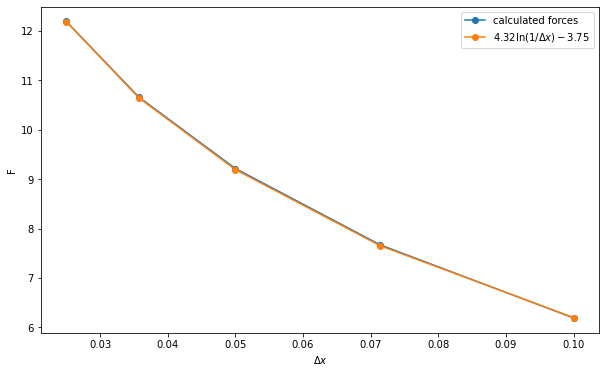

CPU times: user 5.51 s, sys: 80 ms, total: 5.59 s
Wall time: 5.58 s


In [62]:
%%time

Re = 10 # i.e. mu = 0.1

N_values = np.array([10, 14, 20, 28, 40])
forces = []

for N in N_values:
    print(N)
    w, psi, _ = modified_newton_solver(N=N, Re=Re)
    
    force = calculate_force(psi, ny=N + 1, h=1 / N)
    forces.append(force)
    

plt.figure(figsize=(10, 6))
plt.plot(1 / N_values, forces, marker="o", label="calculated forces")
plt.plot(1 / N_values, 4.32 * np.log(N_values) - 3.75, marker="o", label=r"$4.32\ln(1/\Delta x) - 3.75$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")
plt.legend()

plt.show()

# Calculating the flow

## Newton

In [57]:
%%time

N = 40
Re = 620
Re = 10 # i.e. mu = 0.1

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, _ = newton_solver(N=N, Re=Re)

CPU times: user 2.96 s, sys: 109 ms, total: 3.07 s
Wall time: 3.37 s


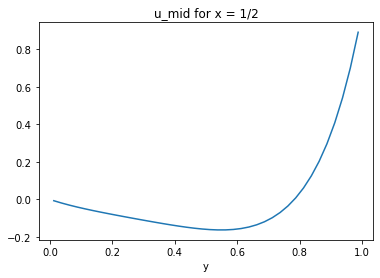

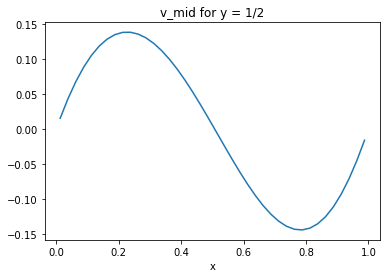

In [59]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[i, :-1] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");
plt.show()

j = ny // 2
v_mid = -(psi[1:, j] - psi[:-1, j]) / h
plt.plot(x_grid[:-1, j] + h / 2, v_mid)
plt.title("v_mid for y = 1/2")
plt.xlabel("x");
plt.show()

In [78]:
def calculate_velocity(psi, h):
    nx = psi.shape[0]
    print(nx)
    
    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    
    u[1:-1, 1:-1] = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * h)
    v[1:-1, 1:-1] = -(psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2 * h)
    
    u[1:-1, -1] = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2
    
    return u, v 

41
(41, 41) (41, 41)


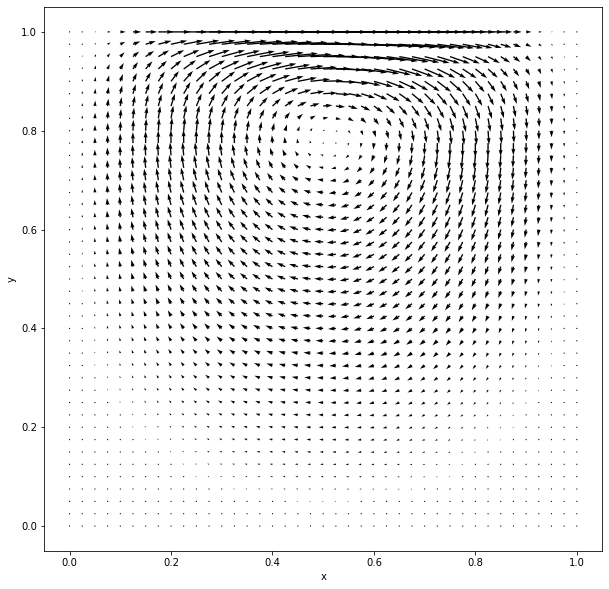

In [84]:
u, v = calculate_velocity(psi=psi, h=h)

print(u.shape, v.shape)
# print(u, v)

assert np.allclose(u[:, -1], np.sin(np.pi * np.arange(psi.shape[0]) * h) ** 2)
assert np.all(u[0, :] == 0)
assert np.all(u[:, 0] == 0)
assert np.all(u[-1, :] == 0)

assert np.all(v[0, :] == 0)
assert np.all(v[:, 0] == 0)
assert np.all(v[-1, :] == 0)
assert np.all(v[:, -1] == 0)

plt.figure(figsize=(10, 10))

# plt.scatter(x_grid, y_grid, s=5)
plt.quiver(x_grid, y_grid, u, v)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [81]:
xyuv = np.vstack([
    x_grid.flatten(), y_grid.flatten(), u.flatten(), v.flatten(),
]).T
print(xyuv.shape)

# np.savetxt('data/vorticity/flow_field.txt', xyuv, delimiter=' ', fmt=['%.2f', '%.18f'])
np.savetxt('data/vorticity/flow_field.txt', xyuv, delimiter=' ', fmt=['%.8f', '%.8f', '%.18f', '%.18f'])

(1681, 4)


## Evolution

In [150]:
%%time

# Stable

dpic = 0.5

N = 40
Re = 10 # i.e. mu = 0.1

tfinal = 3.0

# We'll only need these later
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")

w, psi, omega_mid = solve(N=N, Re=Re, tfinal=tfinal, print_every=dpic)

t=0.50000; w(0.5, 0.5)=-0.5318425795976055
t=1.00000; w(0.5, 0.5)=-0.6392078531937394
t=1.50000; w(0.5, 0.5)=-0.6470209335147183
t=2.00000; w(0.5, 0.5)=-0.6475875194638533
t=2.50000; w(0.5, 0.5)=-0.6476286124379776
t=3.00000; w(0.5, 0.5)=-0.6476315928957449
CPU times: user 29.7 s, sys: 84.2 ms, total: 29.8 s
Wall time: 30.3 s


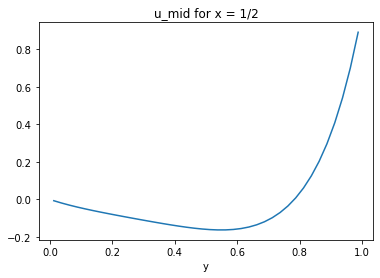

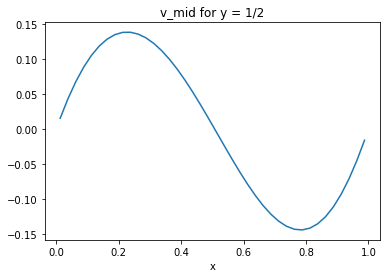

In [151]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[i, :-1] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");
plt.show()

j = ny // 2
v_mid = -(psi[1:, j] - psi[:-1, j]) / h
plt.plot(x_grid[:-1, j] + h / 2, v_mid)
plt.title("v_mid for y = 1/2")
plt.xlabel("x");
plt.show()

(41, 40) (40, 41)


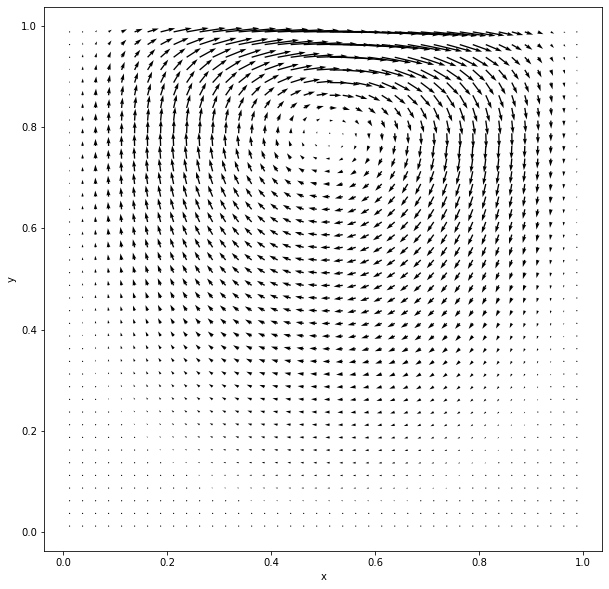

In [152]:
u = (psi[:, 1:] - psi[:, :-1]) / h
v = -(psi[1:, :] - psi[:-1, :]) / h

print(u.shape, v.shape)


plt.figure(figsize=(10, 10))

# plt.scatter(x_grid, y_grid, s=5)
plt.quiver(x_grid[:-1, :-1] + h / 2, y_grid[:-1, :-1] + h / 2, u[:-1, :], v[:, :-1])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Vorticity vs h

5
6
7


No handles with labels found to put in legend.


8


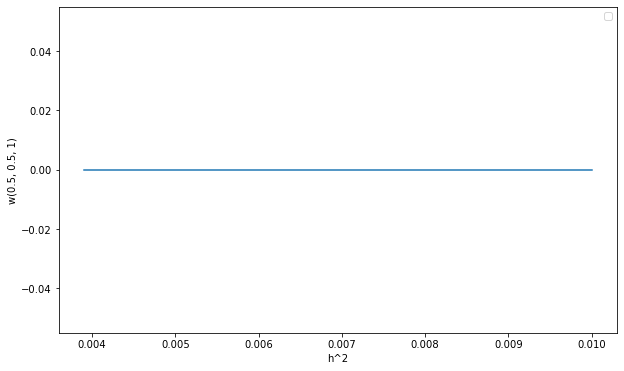

CPU times: user 809 ms, sys: 754 µs, total: 810 ms
Wall time: 810 ms


In [15]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 1.0

plt.figure(figsize=(10, 6))

N_values = np.array([10, 12, 14, 16, 18, 20, 24, 28])
N_values = np.array([10, 12, 14, 16])
values = np.zeros_like(N_values)
for i, N in enumerate(N_values):
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)

    mid_idx = (N + 1) // 2
    print(mid_idx)
    values[i] = psi[mid_idx, mid_idx]


plt.plot(1 / N_values**2, values)    
plt.xlabel("h^2");
plt.ylabel("w(0.5, 0.5, 1)")
plt.legend()

plt.show()

5
6
7


No handles with labels found to put in legend.


8


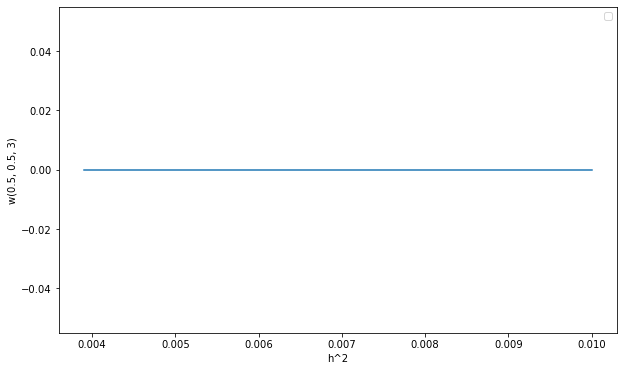

CPU times: user 2.05 s, sys: 3.87 ms, total: 2.05 s
Wall time: 2.06 s


In [16]:
%%time

Re = 10 # i.e. mu = 0.1

tfinal = 3.0

plt.figure(figsize=(10, 6))

N_values = np.array([10, 12, 14, 16, 18, 20, 24, 28])
N_values = np.array([10, 12, 14, 16])
values = np.zeros_like(N_values)
for i, N in enumerate(N_values):
    w, psi, _ = solve(N=N, Re=Re, tfinal=tfinal)

    mid_idx = (N + 1) // 2
    print(mid_idx)
    values[i] = psi[mid_idx, mid_idx]


plt.plot(1 / N_values**2, values)    
plt.xlabel("h^2");
plt.ylabel("w(0.5, 0.5, 3)")
plt.legend()

plt.show()